In [ ]:
clustering

In [1]:
#importing libraries
import os
import re
import requests
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from xml.etree import ElementTree
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
#specifying the path of files
path='C:\Data'
xmlf = []
#storing the files
for rt, di, fi in os.walk(path):
    for fs in fi:
        if '.xml' in fs:
            xmlf.append(os.path.join(rt,fs))
def stprem():
        wstp=[]
        st = stopwords.words('english')
        lem = WordNetLemmatizer()
        dfcols=['preprocessedtext'] 
        #iterating through each xml file 
        for l in xmlf:
            #parsing through xml file as tree       
            tree =ElementTree.parse(l)
            root=tree.getroot()
            lst=[]
            for chd in root:    
           
            #iterating through text data in xml file
            for n in chd.iter('text'):
                for i in n:
                    pt=i.text
                  #removing the special characters,digits
                    reg=re.sub('[\s,*]|\W\d{1,5}[^)(]*|[\s,-]'," ",pt)
                  #lemmatization 
                    r=lem.lemmatize(reg)            
                for word in r.split():
                          #removing stopwords
                        if word not in st:               
                            lst.append(word)
                            pp=lst
                
            wstp.append({"preprocessedtext":pp}) 
        global ppt
        #creating new dataframe with preprocessed text
        ppt=pd.DataFrame(wstp,columns=dfcols)
stprem()

ppt.head()    

,preprocessedtext
0,"[Canadian, Occidental, Petroleum, Ltd., emerge..."
1,"[Bank, America, launch, three, year, ""We, goin..."
2,"[Deutsche, Bank, AG, management, board, member..."
3,"[European, bourses, fell, Tuesday, even, Wall,..."
4,"[French, shares, closed, lower, Tuesday, secon..."


In [2]:
lab=pd.DataFrame()
lst=[]
for l in xmlf:
    biptopic=[]
    
    tree =ElementTree.parse(l)
    root=tree.getroot()
   
    for chd in root:         
        for t in chd.iter('metadata'):
           
            for codes in t.iterfind(".//codes[@class='bip:topics:1.0']"):
                       
                for code in codes.iter("code"):
                           
                    biptopic.append(code.get('code'))
    lst.append(biptopic)                            
         
lab['bip']=lst
dfr=pd.DataFrame()
val=[]
for fl in xmlf:
    name= fl.replace("C:\Data\\","")
    val.append(name)  
dfr['filename']=val   

In [3]:
df1=pd.DataFrame()
df1= pd.concat([ppt,lab,dfr], ignore_index=True, axis=1)
df1.columns = ['text','bip','filename']
df1['text'] = df1['text'].apply(lambda x: ' '.join([w for w in x if len(w)>3]))
df1['text'] = df1['text'].apply(lambda x: x.lower())
df1['text'] = df1['text'].str.replace("[^a-zA-Z#]", " ")
lm = WordNetLemmatizer() 
ps=PorterStemmer()
df1['text'] = df1['text'].apply(lambda x: ' '.join([ps.stem(w) for w in x.split()]))

In [42]:
print(df1.head())

                                                text  \
0  canadian occident petroleum ltd emerg tuesday ...   
1  bank america launch three year go forward synd...   
2  deutsch bank manag board member rolf breuer sa...   
3  european bours fell tuesday even wall street o...   
4  french share close lower tuesday second consec...   

                                 bip          filename  
0                             [C181]  326914newsML.xml  
1                             [C173]  326915newsML.xml  
2                  [C18, C181, CCAT]  326916newsML.xml  
3  [M11, M13, M132, M14, M142, MCAT]  326917newsML.xml  
4                        [G152, M11]  326918newsML.xml  


In [4]:
vectorizer = TfidfVectorizer(max_features=2000,ngram_range=(1,3),max_df=0.50)
y = vectorizer.fit_transform(df1['text'])
X=y.toarray()
terms = vectorizer.get_feature_names()

2 0.009805045098986404
3 0.011580347830924431
4 0.012005966461974474
5 0.013162470978665772
6 0.013469029370577727
7 0.01515875416770231
8 0.016053105556242075


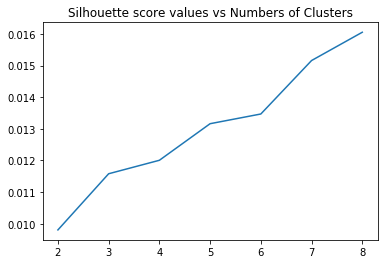

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
scores=[]
k=range(2,9)
for n in k:
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_
    score = silhouette_score (X, preds, metric='euclidean')
    scores.append(score)
    print(n,score)
plt.plot(k,scores)
plt.title("Silhouette score values vs Numbers of Clusters")
plt.show()   

In [6]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=7)
km.fit(X)
labels = km.predict(X)
clusters = km.labels_.tolist()
centroids = km.cluster_centers_
print(centroids)

[[ 8.11864089e-04  1.97156248e-03  6.17720964e-04 ...  4.58009687e-05
   4.07448220e-03  4.83839410e-04]
 [ 3.61569441e-04  1.18461646e-03  7.78264982e-04 ... -1.90277481e-16
   4.98319073e-03  9.35436745e-04]
 [ 1.56334041e-03  3.39570590e-03  1.24181664e-03 ...  1.61906496e-05
   2.56523091e-03  8.21589120e-04]
 ...
 [ 4.59701721e-17  3.08427773e-04 -1.64798730e-17 ...  1.59377719e-17
   3.87627814e-04  8.95062774e-05]
 [ 4.34968922e-05  3.16587034e-17  1.90660124e-04 ...  8.13151629e-18
   1.04083409e-17 -4.33680869e-19]
 [ 4.04063518e-04  1.45362727e-03  3.37160363e-04 ...  2.78057817e-05
   1.78095395e-03  5.75802131e-04]]


In [7]:
df2=pd.Series( (v for v in clusters) )
dff=pd.Series((v for v in X))
lb=[]
for x in (df1['bip']):
        lb.append((str(x).split(',')[0]))
        label=pd.DataFrame()
        label['biptopics']=lb
df3=pd.concat([df1['filename'],df2,dff,label['biptopics'],df1['text']],axis=1)
df3.columns=['filename','clusterid','tfidf','bip1','text']        
df3['bip1'] = df3['bip1'].str.replace('\'', '')
df3['bip1'] = df3['bip1'].str.replace('[', '')
df3['bip1'] = df3['bip1'].str.replace(']', '')

In [43]:
print(df3.head())

           filename  clusterid  \
0  326914newsML.xml          2   
1  326915newsML.xml          2   
2  326916newsML.xml          2   
3  326917newsML.xml          6   
4  326918newsML.xml          6   

                                               tfidf  bip1  \
0  [0.0, 0.0, 0.0, 0.0, 0.06260759881691935, 0.0,...  C181   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  C173   
2  [0.0, 0.0, 0.0, 0.0, 0.05048134746790888, 0.0,...   C18   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   M11   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  G152   

                                                text  
0  canadian occident petroleum ltd emerg tuesday ...  
1  bank america launch three year go forward synd...  
2  deutsch bank manag board member rolf breuer sa...  
3  european bours fell tuesday even wall street o...  
4  french share close lower tuesday second consec...  


In [8]:
from sklearn.model_selection import train_test_split
def split(X1,y1):
         X_train,X_test,y_train,y_test = train_test_split(X1,y1,test_size=0.20)
         return X_train,X_test,y_train,y_test

In [ ]:
classifiers for each cluster

In [9]:
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
temp_df = df3[(df3['clusterid'] == 0)]

bip=encoder.fit_transform(temp_df['bip1'])
warnings.filterwarnings('ignore')
X=temp_df['tfidf'].tolist()
#bip=one.fit_transform(temp_df['bip1'].reshape(1,-1))
y= bip
# split the data into training and testing
X_train,X_test,y_train,y_test = split(X,y)
dtf = tree.DecisionTreeClassifier()
dtf.fit(X_train,y_train)
y_pred=dtf.predict(X_test)
predicted = dtf.predict(X_test)
#calculating accuracy of the classifier
print(metrics.accuracy_score(y_test,y_pred))
print(f1_score(y_test, y_pred, average='macro'))
#labels=np.unique(y_pred)

0.5189340813464236
0.25242687175150313


In [10]:
temp_df1 = df3[(df3['clusterid'] == 1)]
from sklearn import svm
X=temp_df1['tfidf'].tolist()
y= temp_df1['bip1']
X_train,X_test,y_train,y_test=split(X,y)
svmclf = svm.LinearSVC(random_state=0,tol=1e-5, C=1).fit(X_train, y_train)
y_pred=svmclf.predict(X_test)
#evaluating accuracy metric
print(metrics.accuracy_score(y_test,y_pred))
print(f1_score(y_test, y_pred, average='macro')) 

0.8155255124291322
0.5617065575325586


In [11]:
temp_df2 = df3[(df3['clusterid'] == 2)]
from sklearn.linear_model import LogisticRegression
X=temp_df2['tfidf'].tolist()
y= temp_df2['bip1']
X_train,X_test,y_train,y_test=split(X,y)
reg = LogisticRegression(random_state=2, solver='lbfgs',multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
y_pred=reg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro')) 

0.6397265782066747
0.26104974547706955


In [12]:
temp_df3 = df3[(df3['clusterid'] == 3)]
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
X=temp_df3['tfidf'].tolist()
y= temp_df3['bip1']
X_train,X_test,y_train,y_test=split(X,y)
rclfr = RandomForestClassifier(criterion='gini',
                                n_estimators=500, 
                                random_state=1,
                                n_jobs=2)
rclfr.fit(X_train,y_train)

y_pred=rclfr.predict(X_test)

print(metrics.accuracy_score(y_test,y_pred))
print(f1_score(y_test, y_pred, average='macro')) 

0.7458981909970551
0.14910723182702568


In [13]:
temp_df4 = df3[(df3['clusterid'] == 4)]
from sklearn.neural_network import MLPClassifier
X=temp_df4['tfidf'].tolist()
y= temp_df4['bip1']
mlpclf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5,2), random_state=1)
X_train,X_test,y_train,y_test=split(X,y)
mlpclf.fit(X_train, y_train)      
y_pred=mlpclf.predict(X_test)
#calculating accuracy of the classifier
print(metrics.accuracy_score(y_test,y_pred))
print(f1_score(y_test, y_pred, average='macro')) 

0.9756756756756757
0.3958847736625515


In [14]:
temp_df5 = df3[(df3['clusterid'] == 5)]
from sklearn import neighbors
X=temp_df4['tfidf'].tolist()
y= temp_df4['bip1']
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
X_train,X_test,y_train,y_test=split(X,y)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(f1_score(y_test, y_pred, average='macro')) 

0.330150068212824


In [15]:
temp_df6 = df3[(df3['clusterid'] == 6)]
X=temp_df6['tfidf'].tolist()
y= temp_df6['bip1']
X_train,X_test,y_train,y_test=split(X,y)

clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(f1_score(y_test, y_pred, average='macro')) 

0.21974669448031808


In [ ]:
Fetaure Extraction using RNN LSTM

In [16]:
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
word_vectors = dict()
f=open('C:/Data/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
tokenizer = Tokenizer(num_words=6000)
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = word_vectors.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            trainable=False)    
    # Adding 1 because of  reserved 0 index
 
   

Using TensorFlow backend.


In [17]:
def token(cid):    
    if cid==0:
        x= temp_df['text'].values
       
        y = temp_df['bip1'].values
    elif cid==1:
        x= temp_df1['text'].values
        
        y = temp_df1['bip1'].values
                
       
    elif cid==2:
        x= temp_df2['text'].values
        y = temp_df2['bip1'].values
    elif cid==3:
        x= temp_df3['text'].values
        y = temp_df3['bip1'].values
    elif cid==4:
        x= temp_df4['text'].values
        y = temp_df4['bip1'].values
    elif cid==5:
        x= temp_df5['text'].values
        y = temp_df5['bip1'].values
    elif cid==6:
        x= temp_df6['text'].values
        y = temp_df6['bip1'].values
    elif cid==7:
        x= temp_df7['text'].values
        y = temp_df7['bip1'].values  
    x_train,x_test,y_train,y_test = split(x,y)
    
    encoder = LabelEncoder()
    y=encoder.fit_transform(y)
    
    tokenizer.fit_on_texts(x)
    x=tokenizer.texts_to_sequences(x)
    maxlen = 50
    x=pad_sequences(x,maxlen=maxlen)
 
    y=to_categorical(y)
   
    return x,y

In [44]:
from keras import Model
from keras import backend as K
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GlobalMaxPooling1D
from keras.utils import to_categorical
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')


In [ ]:
Application of deep neural network using new features 

In [37]:
for h in range(0,7):
    X,y=token(h)
    print('for cluster id:',h)
    model = Sequential()
    model.add(Embedding(6000,300))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
    layer_output = get_3rd_layer_output([X])
    p=np.asarray(layer_output)

    result = p[0, :,:]
    new=pd.DataFrame()
    new['features']= result.tolist()
    if(h==0):
        temp_df['newfeatures']=new['features'].copy()
    elif(h==1):
        temp_df1['newfeatures']=new['features'].copy()
    elif(h==2):
        temp_df2['newfeatures']=new['features'].copy()
    elif(h==3):
        temp_df3['newfeatures']=new['features'].copy()
    if(h==4):
         temp_df4['newfeatures']=new['features'].copy()
    elif(h==5):
         temp_df5['newfeatures']=new['features'].copy()
    elif(h==6):
         temp_df6['newfeatures']=new['features'].copy()
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    hist2 = model.fit(new['features'],np.array(y), epochs=3, batch_size=2,validation_split=0.4,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
    
   

for cluster id: 0
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 300)         1800000   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, None, 300)         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_14 (Dense)             (None, 42)                2730      
Total params: 1,896,170
Trainable params: 1,896,170
Non-trainable params: 0
_________________________________________________________________
None
Train on 2136 samples, validate on 1425 samples
Epoch 1/3
2136/2136 [==============================] - 52s 24ms/step - loss: 2.4465 - acc: 0.3404 - val_loss: 2.2201 - val_acc: 0.3628
Epoch 2/3
2136/2136 [==============

In [38]:
print(temp_df.head(10))

             filename  clusterid  \
18   368479newsML.xml          0   
34   377576newsML.xml          0   
47   377589newsML.xml          0   
67   393155newsML.xml          0   
82   393170newsML.xml          0   
97   406197newsML.xml          0   
102  406202newsML.xml          0   
307  429607newsML.xml          0   
310  429610newsML.xml          0   
458  429758newsML.xml          0   

                                                 tfidf bip1  \
18   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  M12   
34   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  E11   
47   [0.0, 0.0, 0.05206683607506423, 0.0, 0.0, 0.0,...  C11   
67   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  E12   
82   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  E12   
97   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  C15   
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  M13   
307  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  M13   
310  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [40]:
print(temp_df6.head(10))

            filename  clusterid  \
3   326917newsML.xml          6   
4   326918newsML.xml          6   
5   326919newsML.xml          6   
6   326920newsML.xml          6   
7   368468newsML.xml          6   
13  368474newsML.xml          6   
21  368482newsML.xml          6   
24  377566newsML.xml          6   
26  377568newsML.xml          6   
32  377574newsML.xml          6   

                                                tfidf  bip1  \
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   M11   
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  G152   
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   M11   
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   M14   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   M11   
13  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   M11   
21  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058...   E71   
24  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.122...   M11   
26  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.